这个实验包含了两个任务，第一个是**逻辑回归**，第二个是**正则化的逻辑回归**。

## 逻辑回归
第一部分，我们要判断某个学生能否被大学录取。给定每个学生两门课的成绩，进行逻辑回归训练。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "ex2data1.txt"
data = pd.read_csv(path, header=None, names=['Exam1', 'Exam2', "Admitted"])
data.head()

,Exam1,Exam2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


我们将数据进行可视化，并采用不同的颜色来指示是否被录取

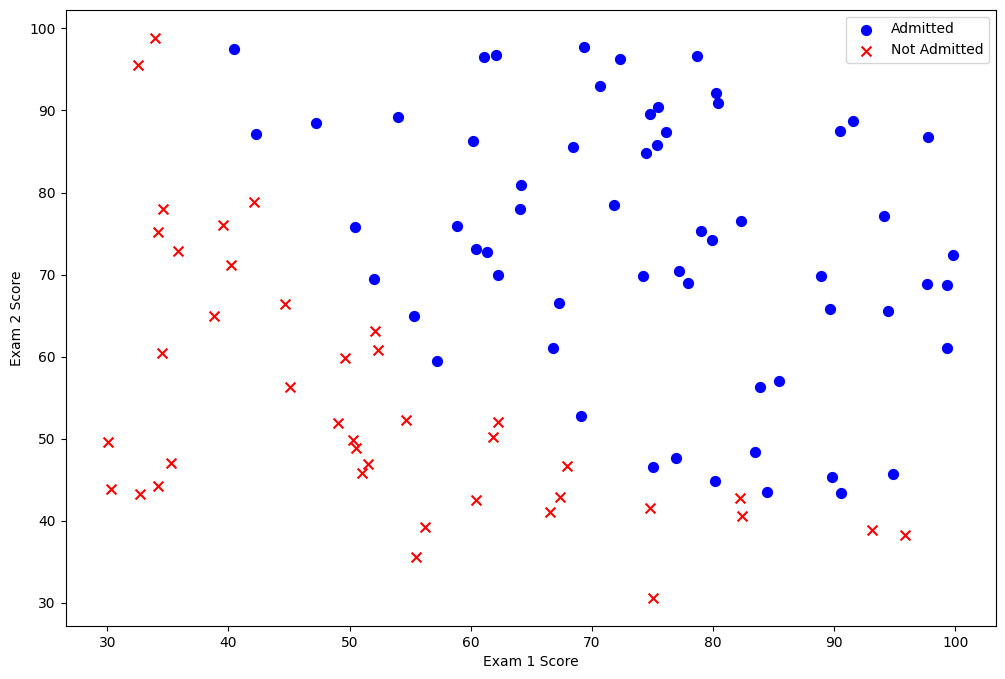

In [7]:
positive = data[data['Admitted'].isin([1])]
negative = data[data['Admitted'].isin([0])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive['Exam1'], positive['Exam2'], s=50, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam1'], negative['Exam2'], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

我们可以看到，在两个区域之间有比较明显的分界。我们进行逻辑回归来分类。

## Sigmoid函数
Simoid函数是常用的逻辑回归函数

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

我们画出Sigmoid函数的图像，可以观察到其值域位于$[0, 1]$

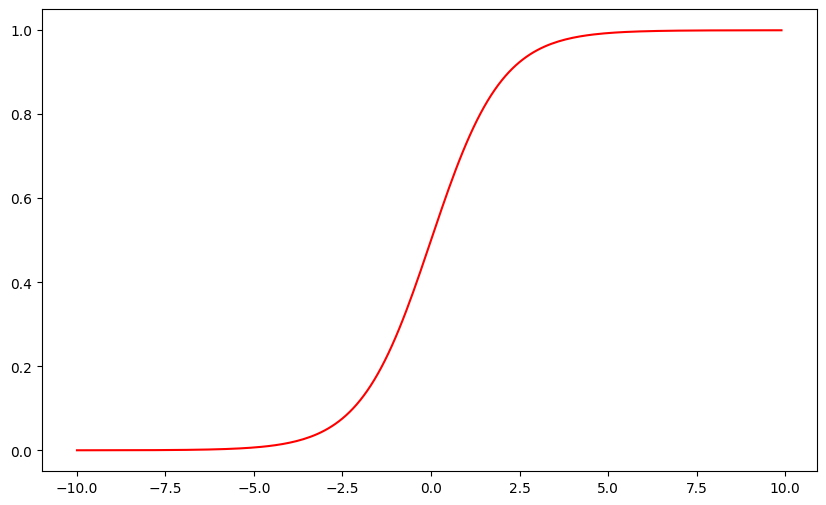

In [11]:
nums = np.arange(-10, 10, step=0.1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(nums, sigmoid(nums), 'r')
plt.show()

接下来我们编写代价函数：
$J\left( \theta \right)=-\frac{1}{m}\sum\limits_{i=1}^{m}{\Big[{{y}^{(i)}}\log \left( {h_\theta}\left( {{x}^{(i)}} \right) \right)+\left( 1-{{y}^{(i)}} \right)\log \left( 1-{h_\theta}\left( {{x}^{(i)}} \right) \right)\Big]}$

In [13]:
def cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(y, np.log(sigmoid(X * theta.T)))
    second = np.multiply(1 - y, np.log(1 - sigmoid(X * theta.T)))
    return -1 / len(X) * np.sum(first + second)

接着，我们做一些与Lab1相似的操作

In [14]:
data.insert(0, 'Ones', 1)
data.head()

,Ones,Exam1,Exam2,Admitted
0,1,34.623660,78.024693,0
1,1,30.286711,43.894998,0
2,1,35.847409,72.902198,0
3,1,60.182599,86.308552,1
4,1,79.032736,75.344376,1


In [20]:
cols = data.shape[1]
X = data.iloc[:, 0 : cols - 1]
y = data.iloc[:, cols - 1:cols]

X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(3)

In [21]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (3,))

计算一下初始的代价函数，$\theta = 0$

In [22]:
cost(theta, X, y)

0.6931471805599453

## 梯度下降
$\theta_j := \theta_j - \alpha\frac{1}{m}\sum_{i = 1}^{m}\big( h_{\theta}(x^{(i)}) - y^{(i)} \big)x_j$

In [35]:
def gradientDescent(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    n = int(theta.ravel().shape[1])
    err = sigmoid(X * theta.T) - y
    res = np.zeros(n)
    for i in range(n):
        term = np.multiply(err, X[:, i])
        res[i] = np.sum(term) / len(X)
    return res

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。在练习中，一个称为“fminunc”的Octave函数是用来计算代价和梯度参数的优化函数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

我们看看初始参数的第一步梯度下降步长

In [36]:
gradientDescent(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [37]:
import scipy.optimize as opt

result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradientDescent, args=(X, y))
result

(array([-25.16131865,   0.20623159,   0.20147149]), 36, 0)

看看在这个结果下的损失函数值是多少

In [38]:
cost(result[0], X, y)

0.20349770158947447

接下来，我们编写一个预测函数，计算假设函数的值，当结果大于等于0.5时，认为这个学生被录取

In [39]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [40]:
predictions = predict(np.matrix(result[0]), X)
correct = [1 if a == b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print('accuracy = {0}%'.format(accuracy))

accuracy = 0.89%


结果看起来还行，对于训练样本达到了89%的准确度

## 正则化逻辑回归
在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。
设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

In [253]:
path = 'ex2data2.txt'
data2 = pd.read_csv(path, header=None, names=['Test1', 'Test2', 'Accepted'])
data2.head()

,Test1,Test2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


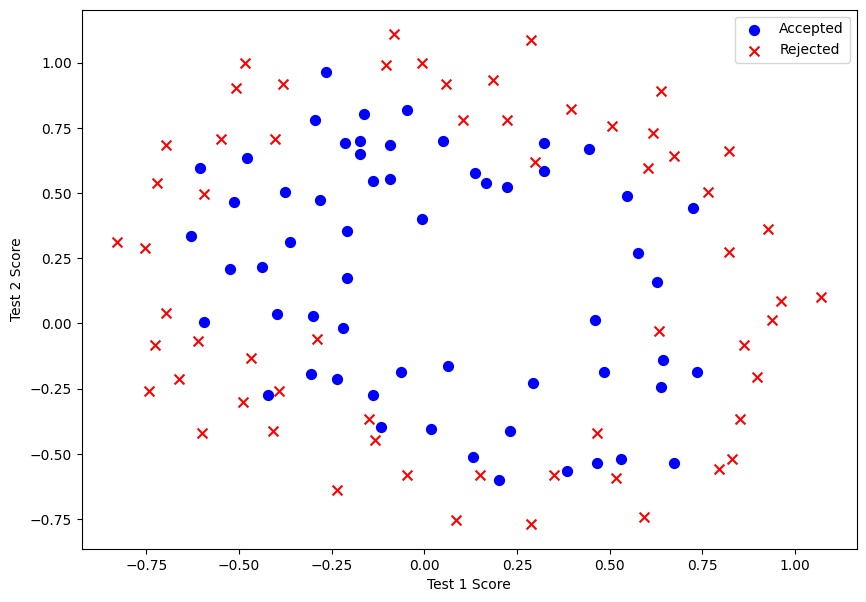

In [254]:
positive = data2[data2['Accepted'].isin([1])]
negative = data2[data2['Accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(10,7))
ax.scatter(positive['Test1'], positive['Test2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative['Test1'], negative['Test2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

可以发现，这个数据比任务一要复杂一些，我们考虑使用二次函数来拟合

In [255]:
data2.insert(3, 'Ones', 1)
x1 = data2['Test1']
x2 = data2['Test2']

degree = 5
# 添加各幂次的样本数据
for i in range(1, degree + 1):
    for j in range(0, i + 1):
        data2['x1^{0} x2^{1}'.format(i - j, j)] = np.power(x1, i - j) * np.power(x2, j)

data2.drop('Test1', axis=1, inplace=True) # 删除原先的两列
data2.drop('Test2', axis=1, inplace=True)

data2.head()

,Accepted,Ones,x1^1 x2^0,x1^0 x2^1,x1^2 x2^0,x1^1 x2^1,x1^0 x2^2,x1^3 x2^0,x1^2 x2^1,x1^1 x2^2,...,x1^3 x2^1,x1^2 x2^2,x1^1 x2^3,x1^0 x2^4,x1^5 x2^0,x1^4 x2^1,x1^3 x2^2,x1^2 x2^3,x1^1 x2^4,x1^0 x2^5
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000094,0.001286,0.017551,0.239497,3.541519e-07,0.000005,0.000066,0.000900,0.012278,0.167542
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,-0.000546,0.004035,-0.029801,0.220095,-6.860919e-06,0.000051,-0.000374,0.002764,-0.020412,0.150752
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,-0.006757,0.021886,-0.070895,0.229642,-4.457837e-04,0.001444,-0.004677,0.015151,-0.049077,0.158970
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,-0.026483,0.035465,-0.047494,0.063602,-7.415771e-03,0.009931,-0.013299,0.017810,-0.023851,0.031940
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,-0.062956,0.057116,-0.051818,0.047011,-3.561597e-02,0.032312,-0.029315,0.026596,-0.024128,0.021890


现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是代价函数：
# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{\Big[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)\Big]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [256]:
def costReg(theta, X, y, lamb): # 正则化后的代价函数
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (lamb / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\Big[\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \Big] \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： 
${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$


In [257]:
def gradientDescentReg(theta, X, y, lamb):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    n = int(theta.ravel().shape[1])
    res = np.zeros(n)
    
    error = sigmoid(X * theta.T) - y
    
    for i in range(n):
        term = np.multiply(error, X[:,i])
        
        if (i == 0):
            res[i] = np.sum(term) / len(X)
        else:
            res[i] = (np.sum(term) / len(X)) + ((lamb / len(X)) * theta[:,i])
    
    return res

然后就像第一部分一样，对数据进行一些初始化操作

In [258]:
cols = data2.shape[1]
X2 = data2.iloc[:, 1 : cols]
y2 = data2.iloc[:, 0 : 1]

X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta2 = np.zeros(cols - 1)

In [259]:
X2.shape, y2.shape, theta2.shape

((118, 21), (118, 1), (21,))

我们调整正则化参数$\lambda$为一个合理的值

In [260]:
lamb = 1
costReg(theta2, X2, y2, lamb)

0.6931471805599454

In [261]:
gradientDescentReg(theta2, X2, y2, lamb)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02])

现在我们可以使用和第一部分相同的优化函数来计算优化后的结果。

In [262]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=gradientDescentReg, args=(X2, y2, lamb))
result2

(array([ 1.27448266,  0.61095046,  1.18628132, -2.17995096, -0.89221289,
        -1.55327868,  0.04332694, -0.36395956, -0.34452325, -0.29818209,
        -1.63377063, -0.04120984, -0.6262418 , -0.25207752, -1.39687897,
        -0.34711344, -0.21300874, -0.04524648, -0.28148897, -0.28326635,
        -0.64855627]),
 31,
 1)

最后，我们可以使用第一部分中的预测函数来查看我们的方案在训练数据上的准确度。

In [263]:
predictions = predict(np.matrix(result2[0]), X2)
correct = [1 if a == b else 0 for (a, b) in zip(predictions, y2)]
accuracy = sum(correct) / len(correct)
print('accuracy = {0}%'.format(accuracy))

accuracy = 0.8389830508474576%
